# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as md
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133407,6,2022,877 YISHUN STREET 81,Khatib,0.475885,12.738721,0.016807,0.000968,"EXECUTIVE, Maisonette",64.583333,145.0,07 TO 09,810000.0
133408,1,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",65.000000,164.0,04 TO 06,785000.0
133409,2,2022,633 YISHUN STREET 61,Khatib,0.774113,13.229106,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.916667,171.0,04 TO 06,842000.0
133410,2,2022,632 YISHUN STREET 61,Khatib,0.700595,13.222912,0.016807,0.000968,"MULTI-GENERATION, Multi Generation",64.750000,164.0,10 TO 12,845000.0


# Data Preprocessing

In [4]:
# The functions in this cell are adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
# It is the same link as the one mentioned in the question paper (Q1b)

def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


In [5]:
from keras import backend as K

def r2(y_true, y_pred): 
    '''
    # Obtained from https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
    # TODO: you have to find out how to use it in your code
    '''
    SS_res = K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Question 1 

### a) Dividing the dataset into train and test using entries from year 2020 and before as training data and 2021, 2022 as test data

In [6]:
# Split data
train_dataframe = pd.DataFrame(df[df.year<=2020])
val_dataframe = pd.DataFrame(df[df.year>2020])

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

### Why is this done instead of using random train/test splits?

We split our data based on years since the data is dependent on time for the final regression prediction. If the data was independent then we could have used a random train test split but since it is dependent we split it based on the above split

We want to use historical data to make future predictions and if we use random split then it implies that the data to predict is interchangeable with the data we are currently training on.

Therefore we would prefer to train on the older (historical) data and take the train/test split with respect to the year rather than a random train/test split.

### b) Prepare an equivalent deep learning model (a neural network with only 1 Dense layer (i.e. no hidden layer) with linear activation and 1 output node)

#### Encoding / standardisation and concatenation and model building

In [7]:
# Categorcial Features encoded as Integers
month = keras.Input(shape=(1,), name="month", dtype="int64")

# Categorcial Features encoded as String
flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")

# Numerical Features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")

all_inputs = [
    month,
    storey_range,
    flat_model_type,
    floor_area_sqm,
    remaining_lease_years,
    degree_centrality,
    eigenvector_centrality,
    dist_to_nearest_stn,
    dist_to_dhoby
]

# Integer Categorical Features
month_encoded = encode_categorical_feature(month, "month", train_ds, False)

# String Categorical Features
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)

# Numerical Features
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

all_features = layers.concatenate(
    [
        month_encoded,
        storey_range_encoded,
        flat_model_type_encoded,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
    ]
)

output = layers.Dense(1, activation='linear')(all_features)
model = keras.Model(all_inputs, output)

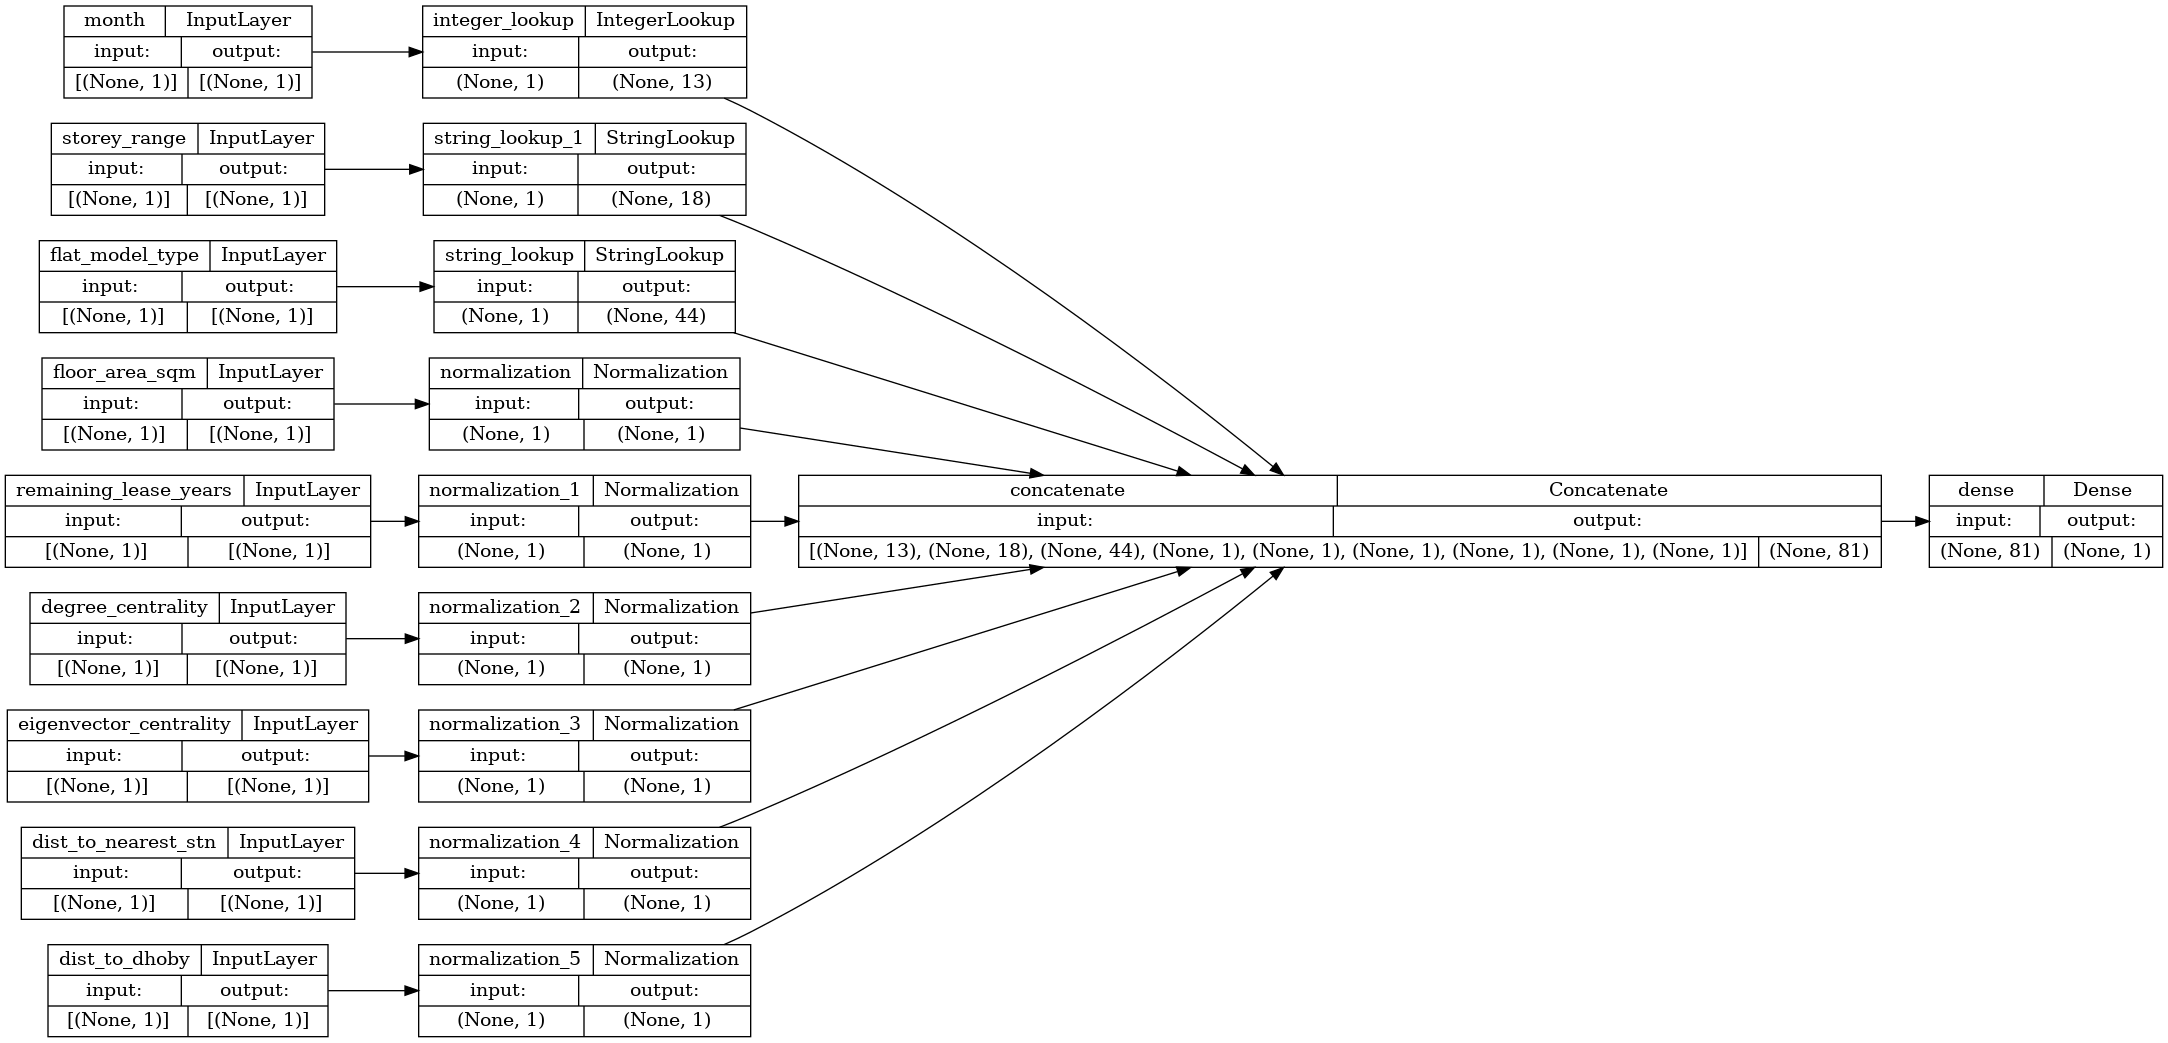

In [8]:
#Visualising the connectivity graph to check if my model architecture 
#is the same as the model architecture in Appendix A
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### c) Train the model for 50 epochs using mini-batch gradient descent with batch size = 256, Adam optimiser (𝛼 = 0.001) and MSE as cost function.

In [9]:
model.compile(keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.mean_squared_error, metrics=[r2])

In [10]:
history_c1 = model.fit(train_ds, epochs=50, batch_size=256, validation_data=val_ds)

Epoch 1/50


/home/NIHALARY001/CZ1016/base/lib/python3.8/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


683/683 [==============================] - 4s 4ms/step - loss: 219585396736.0000 - r2: -8.4602 - val_loss: 301485260800.0000 - val_r2: -10.2279
Epoch 2/50
683/683 [==============================] - 3s 3ms/step - loss: 219582840832.0000 - r2: -8.4693 - val_loss: 301482213376.0000 - val_r2: -10.2229
Epoch 3/50
683/683 [==============================] - 3s 3ms/step - loss: 219580121088.0000 - r2: -8.4812 - val_loss: 301479165952.0000 - val_r2: -10.2411
Epoch 4/50
683/683 [==============================] - 3s 3ms/step - loss: 219577679872.0000 - r2: -8.4737 - val_loss: 301476118528.0000 - val_r2: -10.2286
Epoch 5/50
683/683 [==============================] - 3s 3ms/step - loss: 219575123968.0000 - r2: -8.4645 - val_loss: 301473005568.0000 - val_r2: -10.2643
Epoch 6/50
683/683 [==============================] - 3s 3ms/step - loss: 219572551680.0000 - r2: -8.4660 - val_loss: 301469990912.0000 - val_r2: -10.2535
Epoch 7/50
683/683 [==============================] - 3s 3ms/step - loss: 2195699

#### Test R2 Value

In [11]:
print("Test R2:", history_c1.history["val_r2"][49])

Test R2: -10.194161415100098


### Change the optimiser to SGD (𝛼 = 0.01) and report the R2 value

In [12]:
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss=tf.keras.losses.mean_squared_error, metrics=[r2])

In [13]:
history_c2 = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
683/683 [==============================] - 3s 4ms/step - loss: 12087492608.0000 - r2: 0.4768 - val_loss: 12907530240.0000 - val_r2: 0.5246
Epoch 2/50
683/683 [==============================] - 3s 3ms/step - loss: 4907675648.0000 - r2: 0.7903 - val_loss: 12031177728.0000 - val_r2: 0.5560
Epoch 3/50
683/683 [==============================] - 3s 3ms/step - loss: 4549385728.0000 - r2: 0.8058 - val_loss: 11659524096.0000 - val_r2: 0.5714
Epoch 4/50
683/683 [==============================] - 3s 3ms/step - loss: 4348891136.0000 - r2: 0.8144 - val_loss: 11614636032.0000 - val_r2: 0.5724
Epoch 5/50
683/683 [==============================] - 3s 3ms/step - loss: 4220146432.0000 - r2: 0.8196 - val_loss: 11389794304.0000 - val_r2: 0.5804
Epoch 6/50
683/683 [==============================] - 3s 3ms/step - loss: 4128363008.0000 - r2: 0.8238 - val_loss: 11105672192.0000 - val_r2: 0.5904
Epoch 7/50
683/683 [==============================] - 3s 3ms/step - loss: 4061147136.0000 - r2: 0.8257 - 

####  Test R2 Value

In [14]:
print("Test R2:", history_c2.history["val_r2"][49])

Test R2: 0.6108719706535339


In [15]:
md(f'Test R2 for Adam = **{history_c1.history["val_r2"][49]}** whereas Test R2 for SGD = **{history_c2.history["val_r2"][49]}**')

Test R2 for Adam = **-10.194161415100098** whereas Test R2 for SGD = **0.6108719706535339**

As we can see from the test R2 value the model with SGD optimizer outperforms the model with Adam optimizer

**Adam optimizer** is a combination of the 'gradient descent with momentum' alogrithm and the 'RMSP' algorithm.

    Momentum - This is used to accelerate the gradient descent algorithm by taking into consideration the 'exponentially weighted average' of the gradients. This makes the algorithm converge towards the minima faster.
    
    Root Mean Square Propagation (RMSP) - This is an adaptive learning algorithm which takes the 'exponential moving average'

**SGD** is the most basic form of Gradient Descent. SGD subtracts the gradient multiplied by the learning rate from the weights.

Although Adam converges faster it is said that SGD generalizes better than adam. There is a study which shows that SGD is better than Adam when using the default hyperparamters but Adam is better than SGD while using the fine tuned hyperparamters.

Since we are using a very small learning rate (0.001) in 'Momentum' the gradient descent is heavily dependent on the moving average of gradients and the additional hyperparameter has a very small impact (due to alpha = 0.001). Therefore we conclude that this is probably the reason why Adam optimiser gives us a very poor performance 

Therefore in the first model when we are using Adam optimiser with the default learning rate (0.001) and not fine tuning it we see that the performance is worse than SGD. Later on when we use Adam with 0.08 (tuned hyperparameter) we see that the performance is better than SGD.

### d) Add 1 hidden layer (10 units) to the architecture in Q1c and train with the same configuration in Q1c (i.e. with Adam) with learning rate increased to 0.08 and report the test R2 value

In [16]:
# Adding 1 Hidden layer (10 units) to the architecture in Q1c
x = layers.Dense(10, activation='relu')(all_features)
output = layers.Dense(1, activation='linear')(x)
model = keras.Model(all_inputs, output)

Visualising the connectivity graph to check my model architecture with the new hidden layer

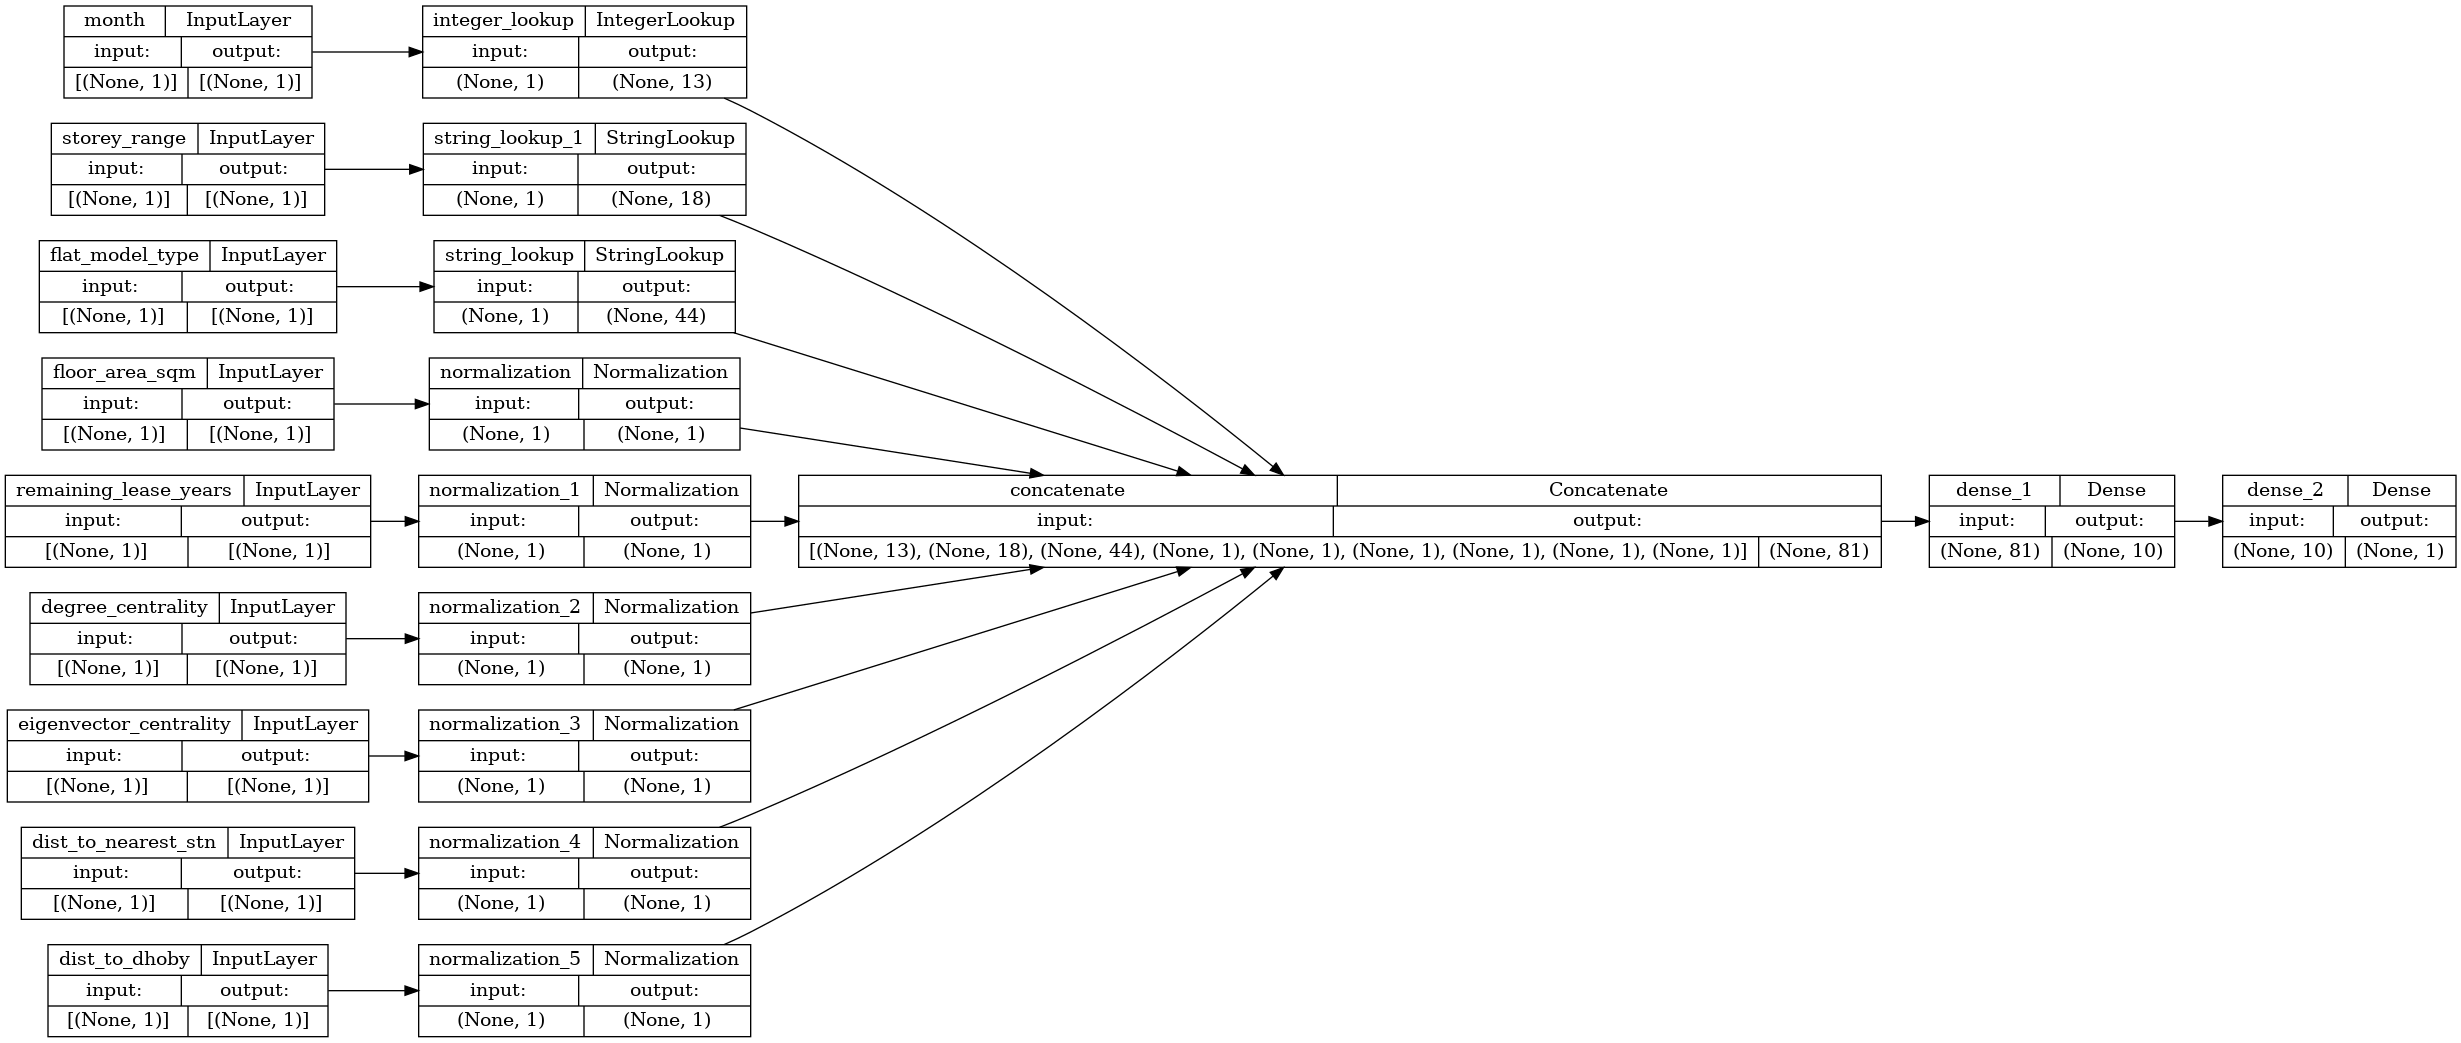

In [17]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [18]:
model.compile(keras.optimizers.Adam(learning_rate=0.08), loss=tf.keras.losses.mean_squared_error, metrics=[r2])

In [19]:
# Training with the same configuration in Q1c with alpha = 0.08
history_d = model.fit(train_ds, epochs=50, batch_size=256, validation_data=val_ds)

Epoch 1/50


/home/NIHALARY001/CZ1016/base/lib/python3.8/site-packages/keras/engine/functional.py:637: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


683/683 [==============================] - 4s 4ms/step - loss: 157932765184.0000 - r2: -5.7858 - val_loss: 96656793600.0000 - val_r2: -2.5883
Epoch 2/50
683/683 [==============================] - 3s 3ms/step - loss: 16204865536.0000 - r2: 0.3078 - val_loss: 14416508928.0000 - val_r2: 0.4705
Epoch 3/50
683/683 [==============================] - 3s 3ms/step - loss: 5200969728.0000 - r2: 0.7782 - val_loss: 12318590976.0000 - val_r2: 0.5474
Epoch 4/50
683/683 [==============================] - 3s 3ms/step - loss: 4626015744.0000 - r2: 0.8028 - val_loss: 11858271232.0000 - val_r2: 0.5636
Epoch 5/50
683/683 [==============================] - 3s 3ms/step - loss: 4276343552.0000 - r2: 0.8175 - val_loss: 11290748928.0000 - val_r2: 0.5838
Epoch 6/50
683/683 [==============================] - 3s 3ms/step - loss: 4056707840.0000 - r2: 0.8267 - val_loss: 11164488704.0000 - val_r2: 0.5887
Epoch 7/50
683/683 [==============================] - 3s 3ms/step - loss: 3911051520.0000 - r2: 0.8326 - val_los

#### Test R2

In [20]:
print("Test R2:", history_d.history["val_r2"][49])

Test R2: 0.6601760983467102


### e) Compare the performance of the linear regression model to the Dense Layer (Q1c) and NN architecture (Q1d)

In [21]:
print(history_c1.history.keys())

dict_keys(['loss', 'r2', 'val_loss', 'val_r2'])


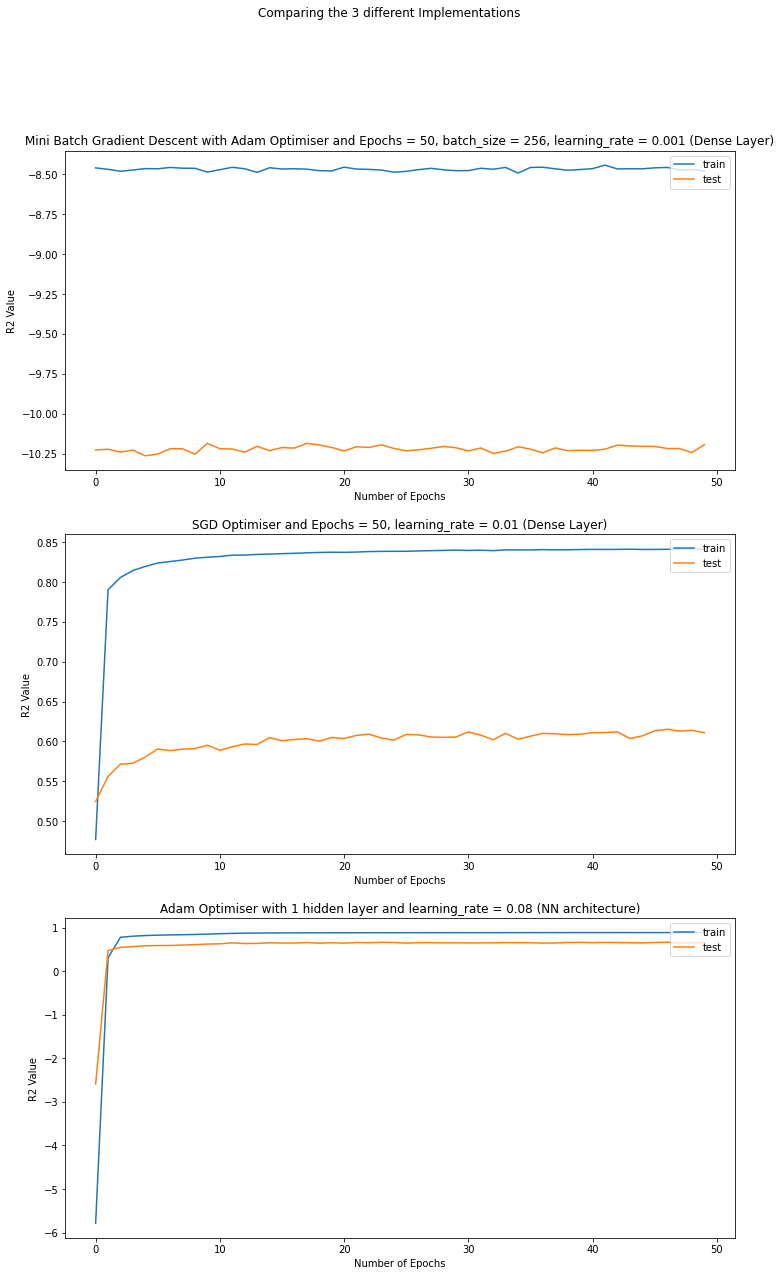

In [22]:
fig, axs = plt.subplots(3)
fig.suptitle('Comparing the 3 different Implementations')
axs[0].plot(history_c1.history["r2"])
axs[0].plot(history_c1.history["val_r2"])
axs[0].set_title('Mini Batch Gradient Descent with Adam Optimiser and Epochs = 50, batch_size = 256, learning_rate = 0.001 (Dense Layer)' )
axs[0].legend(['train', 'test'], loc = 'upper right')
axs[1].plot(history_c2.history["r2"])
axs[1].plot(history_c2.history["val_r2"])
axs[1].set_title('SGD Optimiser and Epochs = 50, learning_rate = 0.01 (Dense Layer)')
axs[1].legend(['train', 'test'], loc = 'upper right')
axs[2].plot(history_d.history["r2"][0:100])
axs[2].plot(history_d.history["val_r2"][0:100])
axs[2].set_title('Adam Optimiser with 1 hidden layer and learning_rate = 0.08 (NN architecture)')
axs[2].legend(['train', 'test'], loc = 'upper right')

fig.set_figheight(20)
fig.set_figwidth(12)

for ax in axs.flat:
    ax.set(xlabel='Number of Epochs', ylabel='R2 Value')

The model with the **NN architecture** uses an adam optimizer with learning rate = 0.08, converges very quickly compared to SGD and this is because models with Adam optimisers tend to converge very quickly.

The model with **Dense Layer SGD** has a slow and steady increase in the test R2 due to the learning rate = 0.01 which causes the model to take relatively small gradient steps. 

The model with **Dense Layer Adam** has a very bad fit due to the negative R2 and does not converge at all.This is probably because we are using Adam without fine tuning it and using the defualt parameters for Adam optimizer which is generally said to give a bad fit to the model.